## Notebook to visualize a dataset


In [1]:
from notebook_imports import *

import torch
from torch.utils.data import DataLoader

from pyrad.data.dataloader import TrainDataloader
from pyrad.data.image_dataset import ImageDataset, PanopticImageDataset
from pyrad.data.image_sampler import CacheImageSampler
from pyrad.data.pixel_sampler import PixelSampler
from pyrad.data.utils import DatasetInputs, get_dataset_inputs_from_dataset_config
from pyrad.graphs.modules.ray_generator import RayGenerator
from pyrad.graphs.modules.scene_colliders import SceneBoundsCollider, AABBBoxCollider
from pyrad.cameras.rays import RayBundle
from pyrad.utils.io import get_absolute_path
from pyrad.viewer.plotly import get_line_segments_from_lines
from pyrad.cameras.cameras import get_camera_model
from pyrad.utils.misc import get_dict_to_torch, instantiate_from_dict_config


from hydra import compose, initialize
from omegaconf import open_dict
import pprint
from tqdm import tqdm
import random

In [2]:
with initialize(version_base=None, config_path="../configs"):
    config = compose(config_name="graph_default.yaml")

In [3]:
dataset_inputs = get_dataset_inputs_from_dataset_config(
    **config.data.dataset_inputs_train, split="train"
)

In [4]:
device = "cpu"

# ImageDataset
image_dataset_train = instantiate_from_dict_config(
    config.data.image_dataset_train, **dataset_inputs.as_dict()
)
# ImageSampler
image_sampler_train = instantiate_from_dict_config(
    config.data.dataloader_train.image_sampler, dataset=image_dataset_train, device=device
)
# PixelSampler
pixel_sampler_train = instantiate_from_dict_config(config.data.dataloader_train.pixel_sampler, keep_full_image=True)

dataloader_train = TrainDataloader(image_sampler_train, pixel_sampler_train)

ray_generator = RayGenerator(dataset_inputs.intrinsics, dataset_inputs.camera_to_world)

iter_dataloader_train = iter(dataloader_train)

num_batches = 10
for _ in tqdm(range(num_batches)):
    ray_indices, batch = next(iter_dataloader_train)
    ray_bundle = ray_generator.forward(ray_indices)
    break

  0%|                                                                                                                                                                                                                         | 0/10 [00:00<?, ?it/s]



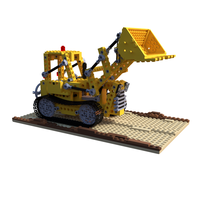

In [5]:
media.show_image(image_dataset_train.get_image(10), height=200)

In [6]:
def show_batch(batch):
    # set the color of the sampled rays
    c, y, x = [i.flatten() for i in torch.split(batch["local_indices"], 1, dim=-1)]
    batch["full_image"][c, y, x] = 0.0

    # batch["image"] is num_images, h, w, 3
    images = torch.split(batch["full_image"], 1, dim=0)
    image_list = [image[0] for image in images]
    image = torch.cat(image_list, dim=1)  # cat along the width dimension

    # the black pixels are rays
    media.show_image((image * 255).to(torch.uint8))


def sample_and_show_batch():
    ray_indices, batch = next(iter_dataloader_train)
    show_batch(batch)
    return batch


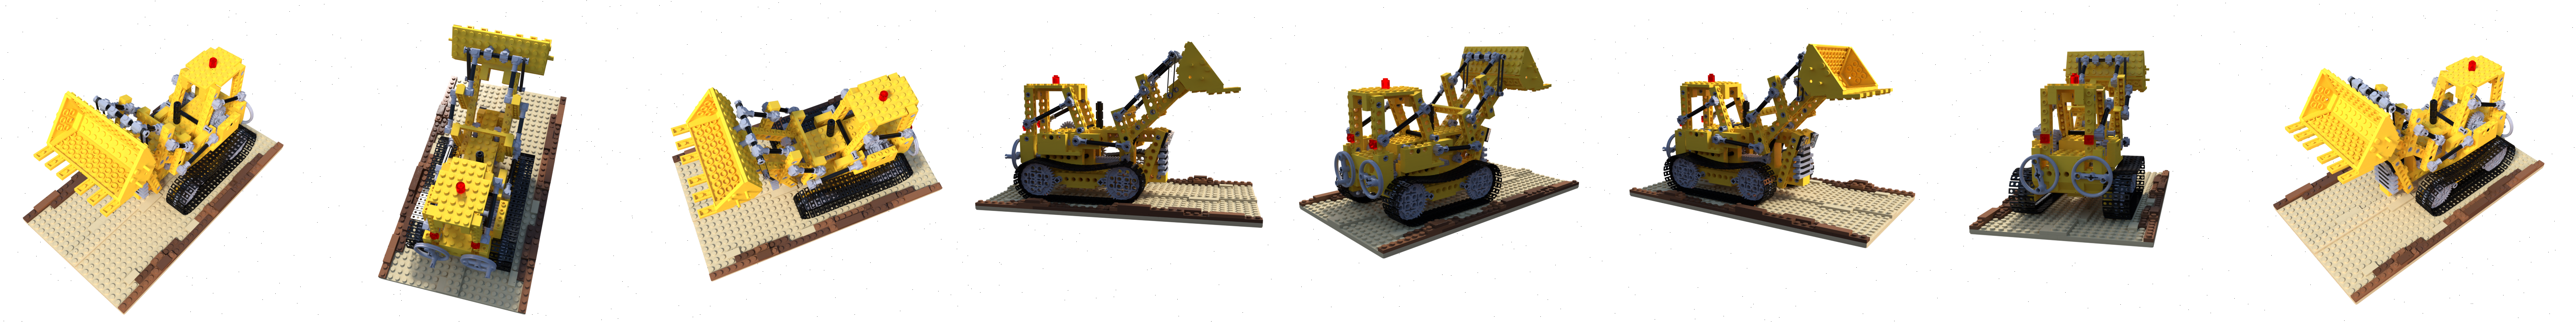

In [7]:
batch = sample_and_show_batch()

In [8]:
ray_indices = batch["indices"]
ray_bundle = ray_generator(ray_indices)

In [9]:
skip = 1
size = 8
data = []
data += [
    go.Scatter3d(
        x=ray_generator.camera_to_world[::skip, 0, 3],
        y=ray_generator.camera_to_world[::skip, 1, 3],
        z=ray_generator.camera_to_world[::skip, 2, 3],
        mode="markers",
        name="origins",
        marker=dict(color="rgba(0, 0, 0, 1)", size=size),
    )
]

In [10]:
scene_bounds_collider = AABBBoxCollider(dataset_inputs.scene_bounds)
intersected_ray_bundle = scene_bounds_collider(ray_bundle)

In [11]:
lines = torch.stack(
    [
        intersected_ray_bundle.origins + intersected_ray_bundle.directions * intersected_ray_bundle.nears[..., None],
        intersected_ray_bundle.origins + intersected_ray_bundle.directions * intersected_ray_bundle.fars[..., None],
    ],
    dim=1,
).tolist()  # (num_rays, 2, 3)
lines = torch.tensor(random.sample(lines, k=100))

In [12]:
data += get_line_segments_from_lines(lines)

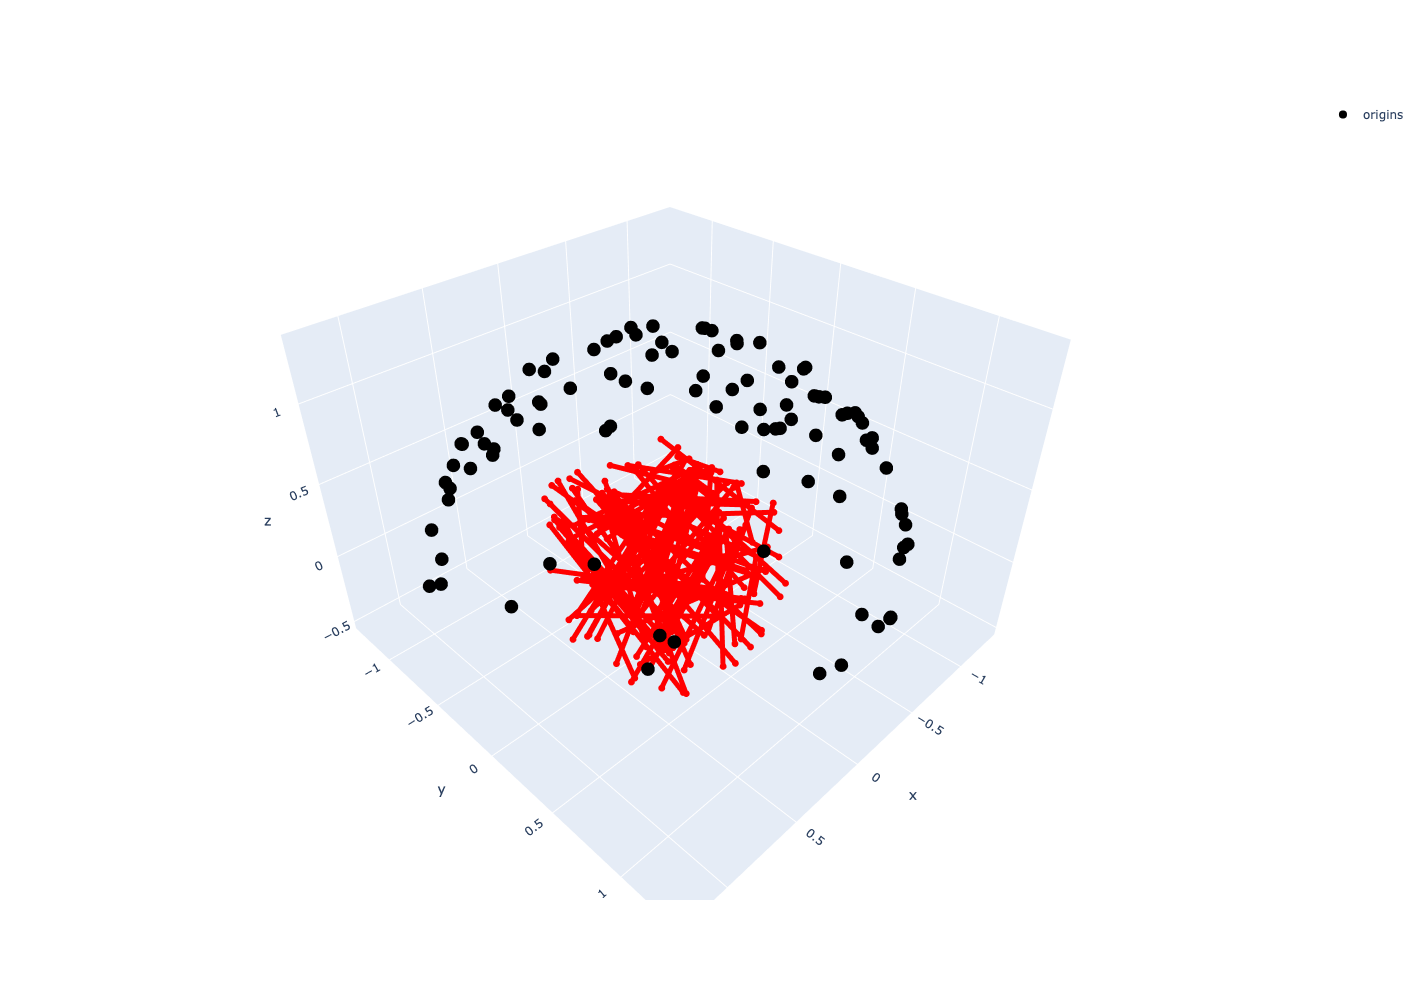

In [13]:
layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,
    margin=go.layout.Margin(l=50, r=50, b=100, t=100, pad=4),
    scene=go.layout.Scene(
        aspectmode="data",
        camera=dict(up=dict(x=0, y=0, z=1), center=dict(x=0, y=0, z=0), eye=dict(x=1.25, y=1.25, z=1.25)),
    ),
)
fig = go.Figure(data=data, layout=layout)
fig.show()